In [1]:
import numpy as np

from sklearn.metrics import confusion_matrix
from hmmlearn import hmm

import gzip
import itertools
import pickle
import time

import matplotlib.pyplot as plt
from ssm.util import find_permutation

%matplotlib inline

In [2]:
def hill_curve_001(x):
    # return 0.185 + (0.867-0.185)*x**1.18 / (68.0**1.18 + x**1.18)
    return (0.168 + (1.07-0.168)*x**0.792 / (112.0**0.792 + x**0.792)) * 100

In [3]:
def make_plots(Z, Z_hat):
    order = Z.argsort()

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,2), sharey=True)
    ax1.imshow(Z[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z.shape[0] - 0.5, 0, 1), cmap="jet")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(Z_hat[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat.shape[0] - 0.5, 0, 1), cmap="jet")
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.show()

    cm = confusion_matrix(Z, Z_hat)

    cm_best_ = cm.copy()
    cm_best_a_ = np.diag(cm_best_).sum()
    for p in itertools.permutations(np.arange(cm.shape[0])):
        cm_ = cm[p, :].copy()
        cm_a_ = np.diag(cm_).sum()
        if cm_a_ > cm_best_a_:
            cm_best_ = cm_.copy()
            cm_best_a_ = cm_a_
    print(cm_best_)
    print(cm_best_a_ / cm_best_.sum())

## Generating Data

In [4]:
K = 3
T = 5000

model_1 = hmm.GaussianHMM(n_components=K, covariance_type="diag")

model_1.startprob_ = np.array([0.6, 0.3, 0.1])
model_1.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.1, 0.8, 0.1],
                            [0.05, 0.05, 0.9]])
model_1.means_ = np.array([[0.0], [50.0], [100.0]])
model_1.covars_ = np.tile(np.ones(1), (K, 1))

def prep_(dat, t=7):
    X, Z = dat
    X_ = X.copy()
    X_ = X_.cumsum()
    X_ = (X_[t:] - X_[:-t])
    X = hill_curve_001(X_+10)
    X, Z = X.reshape(-1, 1), Z[t:]
    return X, Z, dat[0]

sample = [prep_(model_1.sample(T), t=5) for  _ in range(1000)]

X, Z, X_ = np.concatenate([xz[0] for xz  in sample]), np.concatenate([xz[1] for xz  in sample]), np.concatenate([xz[2] for xz  in sample])
L = [len(xz[0]) for xz in sample]

# f = gzip.open('data_hmm_004.pcklz', 'wb')
# pickle.dump(X, f)
# pickle.dump(Z, f)
# f.close()

X[np.isnan(X)] = 0.00

f = gzip.open('data_hmm_004c.pcklz', 'wb')
pickle.dump(X, f)
pickle.dump(Z, f)
f.close()

/tmp/ipykernel_3568607/1592173968.py:3: RuntimeWarning: invalid value encountered in power
  return (0.168 + (1.07-0.168)*x**0.792 / (112.0**0.792 + x**0.792)) * 100


## Regular HMM

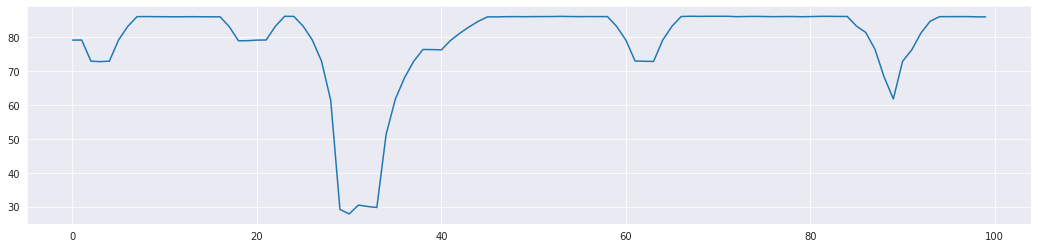

313.0546953678131


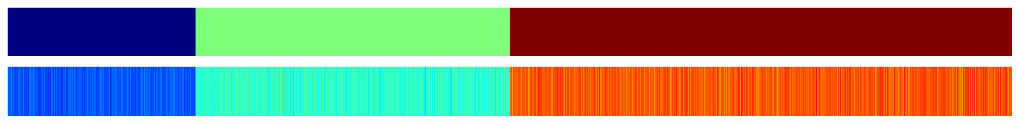

[[ 544660  392279       0]
 [ 293269 1268281       0]
 [  50992  812034 1633485]]
0.6899751751751751


In [5]:
f = gzip.open('data_hmm_004c.pcklz', 'rb')
X = pickle.load(f)
Z = pickle.load(f)
f.close()

plt.figure(figsize=(18,4))
plt.plot(X[:100])
plt.show()

model_r = hmm.GaussianHMM(n_components=K, covariance_type="diag", n_iter=20000, tol=0.0001)
t0 = time.time()
model_r = model_r.fit(X, lengths=L)
print(time.time() - t0)
Z_hat_hmmlearn = model_r.predict(X)

perm = find_permutation(Z_hat_hmmlearn, Z)
make_plots(Z, perm[Z_hat_hmmlearn])

In [6]:
model_r.score(X, lengths=L)

-10089991.586074969

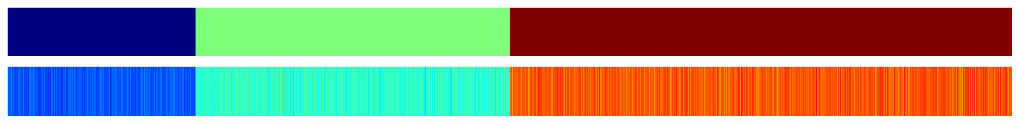

[[ 544660  392279       0]
 [ 293269 1268281       0]
 [  50992  812034 1633485]]
0.6899751751751751


In [7]:
perm_hmmlearn = find_permutation(Z_hat_hmmlearn, Z)
make_plots(Z, perm_hmmlearn[Z_hat_hmmlearn])

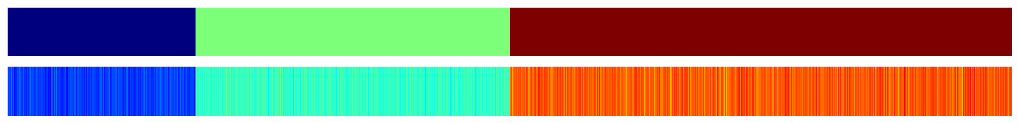

[[ 603460  318186   15293]
 [ 272488 1288333     729]
 [  56368  818160 1621983]]
0.7034586586586586


In [8]:
switch = np.arange(Z_hat_hmmlearn[1:].shape[0])[Z_hat_hmmlearn[1:] != Z_hat_hmmlearn[:-1]] + 1
switch = np.concatenate([np.array([0]), switch])
real_switch = np.concatenate([np.array([0]), switch[1:][(switch[1:] - switch[:-1]) > 3], np.array([Z_hat_hmmlearn.shape[0]])])
Z_hat_post = np.concatenate([(np.bincount(Z_hat_hmmlearn[real_switch[i]:real_switch[i + 1]]).argmax() * np.ones(
    Z_hat_hmmlearn[real_switch[i]:real_switch[i + 1]].shape[0])).astype(int) for i in range(real_switch.shape[0] - 1)])
perm = find_permutation(Z_hat_post, Z)
make_plots(Z, perm[Z_hat_post])

## Gaussian Dense HMM

In [9]:
from models_gaussian_2d import GaussianDenseHMM
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

2022-12-04 20:24:09.360636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 20:24:09.540594: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 20:24:09.540620: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-04 20:24:14.970954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
def compute_stationary(M, verbose=True):
    eigval, eigvec = np.linalg.eig(M.T)
    idx = np.asarray(np.isclose(eigval, [1.], rtol=1e-2, atol=1e-3)).nonzero()[0]
    if idx.size < 1:
        raise Exception("No Eigenvalue 1")
    elif idx.size > 1 and verbose:
        print("Warning: Multiple vectors corresponding to eigenvalue 1.: %s" % str(idx))
    M_stationary = eigvec[:, idx[0]].real
    M_stationary = M_stationary / np.sum(M_stationary)
    return M_stationary

def relu(x):
    return x * (x > 0)

def compute_loss(nodes, splits, n_, omega_gt, means_, covars_, A_):
    B_scalars = None
    if d == 1:  # popraw wizualnie
        B_scalars_tmp = .5 * (
                1 + erf((nodes - np.transpose(a=means_)) / (
                relu(np.transpose(a=covars_[:, :, 0])) + 1e-10) / np.sqrt(2)))

        B_scalars = np.transpose(a=B_scalars_tmp[1:, :] - B_scalars_tmp[:-1, :])
    if d == 2:
        B_scalars_tmp = np.prod(.5 * (
                1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(
            np.transpose(a=means_), axis=0)) / (
                                relu(np.expand_dims(np.transpose(np.array(list(map(lambda x: np.diag(np.array(x)), covars_.tolist())))), axis=0)) + 1e-10) / np.sqrt(2))), axis=1)

        # B_scalars_tmp = np.prod(input_tensor=.5 * (
        #                     1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(
        #                 np.transpose(means_), axis=0)) / (relu(np.expand_dims(np.transpose(covars_),
        #                                                                       axis=0)) + 1e-10) / np.sqrt(2))), axis=1)

            # np.prod(.5 * (
            #     1 + erf((np.expand_dims(nodes, axis=-1) - np.expand_dims(np.transpose(a=means_), axis=0)) /
            #             (relu(np.expand_dims(np.transpose(np.array(list(map(lambda x: np.diag(np.array(x)), covars_.tolist())))), axis=0)) + 1e-10) /
            #             np.sqrt(2))), axis=1)
        B_scalars_tmp_wide = np.reshape(B_scalars_tmp, (*[n.shape[0] for n in splits], n_))
        B_scalars = np.transpose(a=np.reshape(
            B_scalars_tmp_wide[:-1, 1:, :] - B_scalars_tmp_wide[:-1, :-1, :] - B_scalars_tmp_wide[1:, 1:,
                                                                               :] + B_scalars_tmp_wide[1:, :-1, :],
            (-1, n_)))

    A_stationary = compute_stationary(A_, verbose=False)

    theta = A_ * A_stationary[:, None]
    omega = np.matmul(np.transpose(a=B_scalars), np.matmul(theta, B_scalars))
    loss_cooc = np.sum(np.abs(omega_gt - omega)) / 2
    return loss_cooc

def provide_nodes(n_, Y_train):
    kmeans = KMeans(n_).fit(Y_train)
    dtree = DecisionTreeClassifier().fit(Y_train, kmeans.labels_)

    splits = np.concatenate([dtree.tree_.feature.reshape(-1, 1), dtree.tree_.threshold.reshape(-1, 1)], axis=1)
    splits = np.concatenate([splits, np.array([[i, fun(Y_train[:, i])] for i, fun in itertools.product(range(Y_train.shape[1]), [
        lambda x: np.min(x) - 1e-3, lambda x: np.max(x) + 1e-3])])])
    splits = splits[splits[:, 0] >= 0]

    nodes_x = [np.sort(splits[splits[:, 0] == float(i), 1]) for i in np.unique(splits[:, 0])]
    nodes = np.array([t for t in itertools.product(*nodes_x)])

    splits = nodes_x  # number  of splits  on each axis
    discrete_nodes = nodes.astype('float32')
    discrete_observables = [n.shape[0] - 1 for n in nodes_x]

    indexes = np.arange(np.prod(discrete_observables)).reshape(discrete_observables)  # .transpose()
    Y_train_disc = np.array([indexes[i] for i in
                       zip(*[(Y_train[:, j].reshape(-1, 1) > splits[j].reshape(1, -1)).sum(axis=1) - 1 for j in
                             range(len(splits))])])

    return nodes, nodes_x, Y_train_disc

def _lengths_iterator(seqs, lengths):
    n_seqs = len(lengths)
    left, right = 0, 0

    for i in range(len(lengths)):
        right += lengths[i]
        yield seqs[left:right]
        left += lengths[i]

def empirical_coocs(seqs, m, lengths=None):
    freqs = np.zeros((m, m))
    seq_iterator = seqs
    if lengths is not None:
        seq_iterator = _lengths_iterator(seqs, lengths)

    for seq in seq_iterator:

        if seq.shape[0] <= 1:  # no transitions
            continue

        seq = seq.reshape(-1)

        seq_pairs = np.dstack((seq[:-1], seq[1:]))
        seq_pairs, counts = np.unique(seq_pairs, return_counts=True, axis=1)
        seq_pre, seq_suc = [arr.flatten() for arr in np.dsplit(seq_pairs, 2)]
        freqs[seq_pre, seq_suc] += counts

    return freqs, freqs / np.sum(freqs)

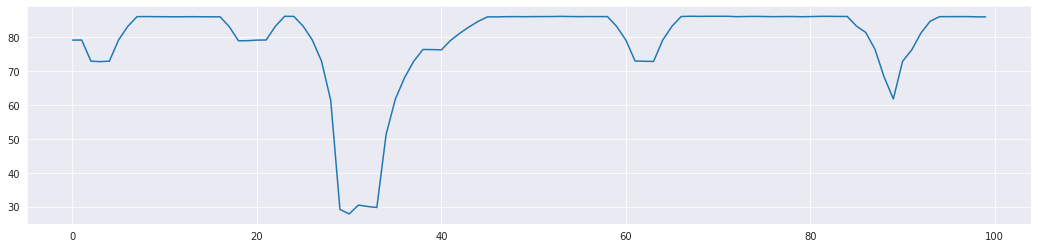

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2022-12-04 20:25:04.253578: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-04 20:25:04.253631: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 20:25:04.253659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cymestmp): /proc/driver/nvidia/version does not exist
2022-12-04 20:25:04.256093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 20:25:04.367892: I tensorflow/compiler/mlir/mlir_graph_optimizat

0.43244706698451774


         2   -67671498.9528    +2044574.1146


0.11488592903576873


         3   -67260865.1153     +410633.8374


0.09724372396528524


         4   -66504193.3039     +756671.8114


0.0962833159880006


         5   -65708771.6423     +795421.6616


0.09503614255448414


         6   -64964689.7987     +744081.8436


0.09357788467311053


         7   -64301001.0537     +663688.7451


0.09203066964567437


         8   -63725738.6819     +575262.3718


0.09046649568259524


         9   -63235733.3019     +490005.3800


0.08894603663100478


        10   -62821525.6280     +414207.6738


0.0875160057259716


        11   -62471125.5809     +350400.0472


0.08620380545661344


        12   -62172586.5075     +298539.0734


0.08501815143861302


        13   -61915383.0778     +257203.4296


0.08395366609153823


        14   -61690897.4833     +224485.5945


0.08299626057918434


        15   -61492380.8654     +198516.6179


0.08212754395974338


        16   -61314676.3723     +177704.4932


0.0813277997638067


        17   -61153881.3624     +160795.0099


0.08057771320642655


        18   -61007037.9164     +146843.4459


0.07985921206494256


        19   -60871884.2158     +135153.7006


0.07915575490697949


        20   -60746669.1593     +125215.0565


0.07845231157929154


        21   -60630019.8177     +116649.3416


0.07773519545460328


        22   -60520848.2004     +109171.6172


0.0769918423844986


        23   -60418285.0473     +102563.1531


0.0762105870584186


        24   -60321630.9957      +96654.0516


0.07538045784880561


        25   -60230318.1676      +91312.8281


0.07449099047384146


        26   -60143877.5109      +86440.6567


0.07353204464850956


        27   -60061909.1017      +81968.4092


0.07249359381621724


        28   -59984054.1892      +77854.9126


0.07136544526003553


        29   -59909969.1535      +74085.0357


0.07013683707158927


        30   -59839302.8038      +70666.3497


0.06879585138287872


        31   -59771679.5433      +67623.2605


0.0673285823033723


        32   -59706691.8709      +64987.6723


0.06571800489425604


        33   -59643906.5362      +62785.3348


0.06394251243839846


        34   -59582889.6363      +61016.8998


0.06197413277358902


        35   -59523257.3916      +59632.2447


0.059776524367132496


        36   -59464761.5062      +58495.8854


0.05730304333017427
147.9425027370453


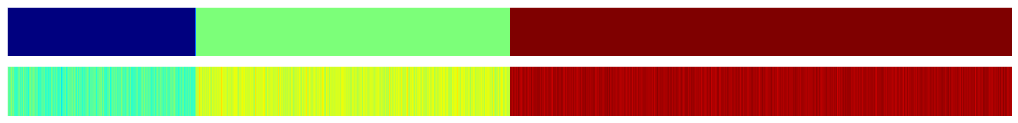

[[ 306410  430756  199773]
 [  64186 1101043  396321]
 [      0  177688 2318823]]
0.7460012012012012


In [11]:
f = gzip.open('data_hmm_004c.pcklz', 'rb')
X = pickle.load(f)
Z = pickle.load(f)
f.close()

plt.figure(figsize=(18,4))
plt.plot(X[:100])
plt.show()

n = 3
d = 1
Y = X
lengths = np.array([Y.shape[0]])

nodes, splits, Y_disc = provide_nodes(n, Y)
_, omega_gt = empirical_coocs(Y_disc.reshape(-1, 1), np.max(Y_disc) + 1, lengths=lengths)
model = GaussianDenseHMM(n_hidden_states=n, mstep_config={'cooc_epochs': 12000 * n, 'cooc_lr': 0.003, 'loss_type': 'square'}, n_dims=d,
                         verbose=True, early_stopping=True, convergence_tol=0.0001, covariance_type='diag')
t0 = time.time()
model.fit_coocs(Y, lengths=L)
print(time.time() - t0)
Z_hat = model.predict(Y, L)

perm = find_permutation(Z_hat, Z)
make_plots(Z, perm[Z_hat])

In [12]:
model.score(Y, lengths=L)

-59407477.182528004

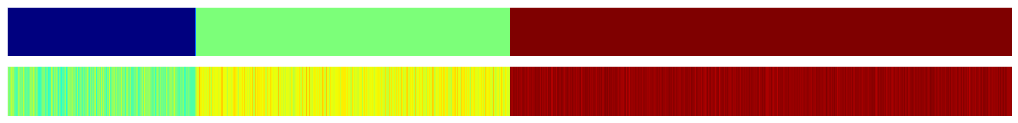

[[ 279255  390177  267507]
 [  33888 1075223  452439]
 [   2173  100423 2393915]]
0.7504290290290291


In [13]:
switch = np.arange(Z_hat[1:].shape[0])[Z_hat[1:] != Z_hat[:-1]] + 1
switch = np.concatenate([np.array([0]), switch])
real_switch = np.concatenate([np.array([0]), switch[1:][(switch[1:] - switch[:-1]) > 3], np.array([Z_hat.shape[0]])])
Z_hat_post = np.concatenate([(np.bincount(Z_hat[real_switch[i]:real_switch[i + 1]]).argmax() * np.ones(
    Z_hat[real_switch[i]:real_switch[i + 1]].shape[0])).astype(int) for i in range(real_switch.shape[0] - 1)])
perm = find_permutation(Z_hat_post, Z)
make_plots(Z, perm[Z_hat_post])

In [14]:
def make_plots2(Z, Z_hat, Z_hat2):
    order = Z.argsort()

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,2), sharey=True)
    ax1.imshow(Z[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z.shape[0] - 0.5, 0, 1), cmap="rainbow")
    ax1.set_xticks([])
    # plt.sca(ax1)
    ax2.set_yticks([])
    ax1.set_ylabel("Ground Truth", rotation=0, ha='right')

    ax2.imshow(Z_hat[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat.shape[0] - 0.5, 0, 1), cmap="rainbow")
    ax2.set_xticks([])
    # plt.sca(ax2)
    ax2.set_yticks([])
    ax2.set_ylabel("Standard Gaussian HMM", rotation=0, ha='right')

    ax3.imshow(Z_hat2[order].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat2.shape[0] - 0.5, 0, 1), cmap="rainbow")
    ax3.set_xticks([])
    # plt.sca(ax3)
    ax2.set_yticks([])
    ax3.set_ylabel("Gaussian Dense HMM", rotation=0, ha='right')
    plt.suptitle("Overall Consistency of the States")
    plt.show()

    cm = confusion_matrix(Z_hat2, Z_hat)

    cm_best_ = cm.copy()
    cm_best_a_ = np.diag(cm_best_).sum()
    for p in itertools.permutations(np.arange(cm.shape[0])):
        cm_ = cm[p, :].copy()
        cm_a_ = np.diag(cm_).sum()
        if cm_a_ > cm_best_a_:
            cm_best_ = cm_.copy()
            cm_best_a_ = cm_a_
    print(cm_best_)
    print(cm_best_a_ / cm_best_.sum())

In [15]:
perm = find_permutation(Z_hat, Z)

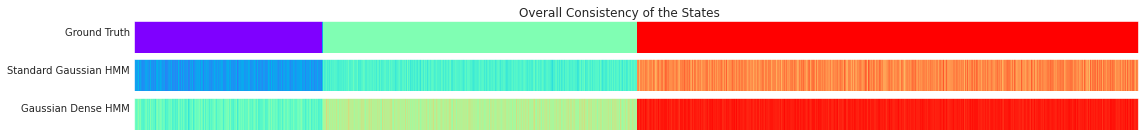

[[ 370596       0       0]
 [ 518321 1191166       0]
 [      4 1281428 1633485]]
0.6396890890890891


In [16]:
make_plots2(Z, perm_hmmlearn[Z_hat_hmmlearn], perm[Z_hat])

In [17]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 0].mean())
print((Z != perm_hmmlearn[Z_hat_hmmlearn])[perm_hmmlearn[Z_hat_hmmlearn] != 0].mean())

0.5813185276736266
0.2933000071357614


In [18]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 1].mean())
print((Z != perm_hmmlearn[Z_hat_hmmlearn])[perm_hmmlearn[Z_hat_hmmlearn] != 1].mean())

0.8121936537414748
0.13648120088518662


In [19]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 2].mean())
print((Z != perm_hmmlearn[Z_hat_hmmlearn])[perm_hmmlearn[Z_hat_hmmlearn] != 2].mean())

0.6543071510600194
0.4606774028972056


In [20]:
print((Z == perm[Z_hat])[Z == 0].mean())
print((Z != perm[Z_hat])[perm[Z_hat] != 0].mean())
print((Z == perm[Z_hat])[Z == 1].mean())
print((Z != perm[Z_hat])[perm[Z_hat] != 1].mean())
print((Z == perm[Z_hat])[Z == 2].mean())
print((Z != perm[Z_hat])[perm[Z_hat] != 2].mean())

0.32703302989842453
0.2604742146231168
0.7050962185008485
0.20096709402762977
0.9288254688242912
0.3233669041091149


In [31]:
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 0].mean())
print(((Z != 0) == (perm_hmmlearn[Z_hat_hmmlearn] != 0))[Z != 0].mean())
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 1].mean())
print(((Z != 1) == (perm_hmmlearn[Z_hat_hmmlearn] != 1))[Z != 1].mean())
print((Z == perm_hmmlearn[Z_hat_hmmlearn])[Z == 2].mean())
print(((Z != 2) == (perm_hmmlearn[Z_hat_hmmlearn] != 2))[Z != 2].mean())
print((Z == perm[Z_hat])[Z == 0].mean())
print(((Z != 0) == (perm[Z_hat] != 0))[Z != 0].mean())
print((Z == perm[Z_hat])[Z == 1].mean())
print(((Z != 1) == (perm[Z_hat] != 1))[Z != 1].mean())
print((Z == perm[Z_hat])[Z == 2].mean())
print(((Z != 2) == (perm[Z_hat] != 2))[Z != 2].mean())

0.5813185276736266
0.9151661347623902
0.8121936537414748
0.6492411422912814
0.6543071510600194
1.0
0.32703302989842453
0.9841830864543436
0.7050962185008485
0.8227893226929182
0.9288254688242912
0.7614182011607816


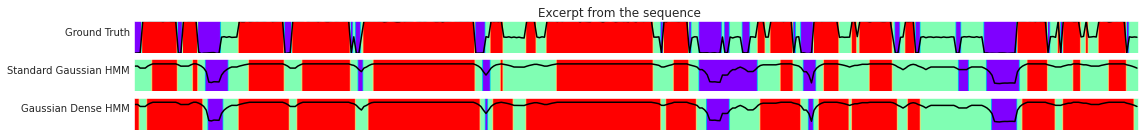

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,2), sharey=True)
ax1.plot(X_[5:400], color='Black')
ax1.imshow(Z[:395].reshape(1, -1), aspect="auto", extent=(-0.5, Z[:395].shape[0] - 0.5, 0, 110), cmap="rainbow")
ax1.set_xticks([])
# plt.sca(ax1)
ax2.set_yticks([])
ax1.set_ylabel("Ground Truth", rotation=0, ha='right')

ax2.plot(X[:395], color='Black')
ax2.imshow(perm_hmmlearn[Z_hat_hmmlearn][:395].reshape(1, -1)[:100], aspect="auto", extent=(-0.5, Z_hat_hmmlearn[5:400].shape[0] - 0.5, 0, 100), cmap="rainbow")
ax2.set_xticks([])
# plt.sca(ax2)
ax2.set_yticks([])
ax2.set_ylabel("Standard Gaussian HMM", rotation=0, ha='right')

ax3.plot(X[:395], color='Black')
ax3.imshow(perm[Z_hat][:395].reshape(1, -1), aspect="auto", extent=(-0.5, Z_hat[5:400].shape[0] - 0.5, 0, 100), cmap="rainbow")
ax3.set_xticks([])
# plt.sca(ax3)
ax2.set_yticks([])
ax3.set_ylabel("Gaussian Dense HMM", rotation=0, ha='right')
plt.suptitle("Excerpt from the sequence")
plt.show()

In [22]:
X_.max()

104.9871755961221

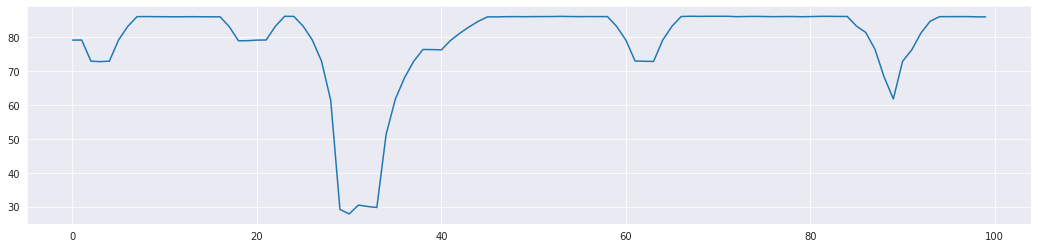

         1   -76663270.8842             +nan


0.729711105151971


         2   -72659141.5881    +4004129.2962


0.6054769328228201


         3   -68219713.0160    +4439428.5721


0.40383967710284063


         4   -65693667.1129    +2526045.9031


0.2537875388328559


         5   -65045677.4870     +647989.6260


0.1365456399273325


         6   -65365068.6544     -319391.1674


0.0401766106246205


         7   -65756181.2679     -391112.6135


0.014736582531174108


         8   -65946235.7847     -190054.5168


0.00875939761950394


         9   -66026189.7695      -79953.9848


0.006472101320319834


        10   -66050462.8779      -24273.1084


0.005344917355792092


        11   -66042070.2284       +8392.6494


0.004720267236008982


        12   -66012343.4784      +29726.7500


0.004341543881498194


        13   -65968107.7143      +44235.7641


0.004091145583086832


        14   -65914053.6278      +54054.0866


0.00391111132514104


        15   -65853617.5337      +60436.0941


0.003771489309897323


        16   -65789383.5748      +64233.9589


0.0036562418834161555


        17   -65723309.6610      +66073.9138


0.0035565507851012318


        18   -65656873.7474      +66435.9136


0.0034674749135508104


        19   -65591176.7983      +65696.9491


0.0033862087580490054


        20   -65527019.2244      +64157.5739


0.003311141079655906


        21   -65464959.9658      +62059.2587


0.0032413308795091107


        22   -65405363.7170      +59596.2488


0.0031762094501297375


        23   -65348439.6999      +56924.0171


0.0031154091142362645


        24   -65294274.1023      +54165.5976


0.0030586649594906965


        25   -65242857.5013      +51416.6010


0.003005759498513729


        26   -65194108.0987      +48749.4026


0.002956492846175243


        27   -65147891.3167      +46216.7821


0.0029106680445780287


        28   -65104036.1498      +43855.1669


0.0028680852213631984


        29   -65062348.6033      +41687.5465


0.0028285406860892753


        30   -65022622.5205      +39726.0828


0.0027918285589642144


        31   -64984648.0978      +37974.4227


0.002757743467083964


        32   -64948218.3854      +36429.7124


0.0027260834472599667


        33   -64913134.0670      +35084.3184


0.002696652583560247


        34   -64879206.8011      +33927.2658


0.0026692631553770774


        35   -64846261.3876      +32945.4135


0.0026437372247862865


        36   -64814136.9978      +32124.3898


0.002619907681159697


        37   -64782687.6801      +31449.3177


0.002597618807832855


        38   -64751782.3208      +30905.3592


0.0025767264551596306


        39   -64721304.2119      +30478.1089


0.0025570979070917263


        40   -64691150.3476      +30153.8643


0.002538611521812196


        41   -64661230.5487      +29919.7989


0.002521156215805142


        42   -64631466.4899      +29764.0588


0.002504630848153464


        43   -64601790.6867      +29675.8031


0.002488943549641018


        44   -64572145.4847      +29645.2020


0.0024740110303466127


        45   -64542482.0785      +29663.4062


0.0024597578902400474


        46   -64512759.5820      +29722.4964


0.002446115949873838


        47   -64482944.1604      +29815.4216


0.002433023612464686


        48   -64453008.2301      +29935.9303


0.0024204252642572237


        49   -64422929.7299      +30078.5002


0.0024082707168080982


        50   -64392691.4617      +30238.2682


0.002396514692490651


        51   -64362280.4983      +30410.9633


0.0023851163528896286


        52   -64331687.6548      +30592.8436


0.002374038868663264


        53   -64300907.0174      +30780.6373


0.0023632490287555682


        54   -64269935.5274      +30971.4901


0.0023527168864362165


        55   -64238772.6119      +31162.9155


0.002342415439450173


        56   -64207419.8593      +31352.7525


0.002332320341504884


        57   -64175880.7332      +31539.1262


0.00232240964236882


        58   -64144160.3201      +31720.4131


0.0023126635539632303


        59   -64112265.1089      +31895.2112


0.0023030642399776077


        60   -64080202.7960      +32062.3129


0.00229359562670859
206.86433482170105


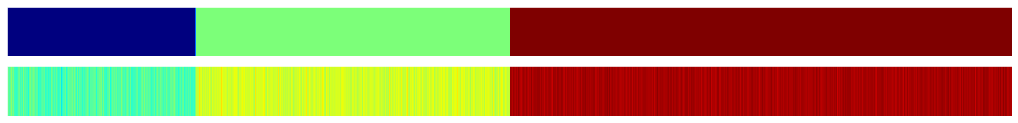

[[ 306410  430796  199733]
 [  64186 1101251  396113]
 [      0  177690 2318821]]
0.7460424424424424


In [28]:
f = gzip.open('data_hmm_004c.pcklz', 'rb')
X = pickle.load(f)
Z = pickle.load(f)
f.close()

plt.figure(figsize=(18,4))
plt.plot(X[:100])
plt.show()

n = 3
d = 1
Y = X
lengths = np.array([Y.shape[0]])

nodes, splits, Y_disc = provide_nodes(n, Y)
_, omega_gt = empirical_coocs(Y_disc.reshape(-1, 1), np.max(Y_disc) + 1, lengths=lengths)
model2 = GaussianDenseHMM(n_hidden_states=n, mstep_config={'cooc_epochs': 20000 * n, 'cooc_lr': 0.003, 'loss_type': 'square'}, n_dims=d,
                         verbose=True, early_stopping=True, convergence_tol=0.0001, covariance_type='diag')
t0 = time.time()
model2.fit_coocs(Y, lengths=L)
print(time.time() - t0)
Z_hat2 = model2.predict(Y, L)

perm2 = find_permutation(Z_hat2, Z)
make_plots(Z, perm2[Z_hat2])